# Sanity check
This script is intented to record the decision making process

In [19]:
pip install seaborn

  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
Note: you may need to restart the kernel to use updated packages.


## Check 1: Simulation start and end
Check if with the new simBEV data, 7:00 is still the best start and end of the simulation time, also overthink whether the simulation has to start on a Monday

In [20]:
# import necessary packages for this section
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# define the base path
root_dir = r"H:\Grids"

In [4]:
def import_flexibility_bands(dir, use_cases):
    BANDS = ["upper_power", "upper_energy", "lower_energy"]
    flexibility_bands = {}

    for band in BANDS:
        band_df = pd.DataFrame()
        for use_case in use_cases:
            flexibility_bands_tmp = \
                pd.read_csv(dir+'/{}_{}.csv'.format(band, use_case),
                            index_col=0, parse_dates=True, dtype=np.float32)
            band_df = pd.concat([band_df, flexibility_bands_tmp],
                                axis=1)
        if band_df.columns.duplicated().any():
            raise ValueError("Charging points with the same name in flexibility bands. "
                             "Please check")
        flexibility_bands[band] = band_df
        # remove numeric problems
        if "upper" in band:
            flexibility_bands[band] = flexibility_bands[band] + 1e-5
        elif "lower" in band:
            flexibility_bands[band] = flexibility_bands[band] - 1e-5
    return flexibility_bands

In [76]:
# 2D heatmap with monthly-hourly resolution
def plot_hm_quarterly_percent(df_power, df_energy, v_max=None, filename=None, title=None, figsize=(6, 2.25)):

    
    fig, ax =  plt.subplots(1, 2, figsize=figsize)
    plt.subplots_adjust(bottom=0.3)
    v_min = 0
    v_max = None

    df = pd.DataFrame(df_power)

    df['quarter_of_day'] = df.index.hour * 4 + np.floor(df.index.minute/15)
    df["weekday"] = (df.index.weekday+2)%7
    grouped = df.groupby(["weekday", 'quarter_of_day']).mean().unstack()
    grouped.columns = ["{}:{}".format(int(d/4), (d%4)*15) for d in grouped.columns.get_level_values(1)]
    grouped.index = [calendar.day_name[m][0:3] for m in grouped.index]

    g = sns.heatmap(grouped, cmap='Reds', xticklabels=False, vmin=v_min, vmax=v_max, ax=ax[0],
                    cbar=True, linewidths=0)  
    g.set_xticks(np.arange(0, 97, 48))
    g.set_xticklabels(['00:00', '12:00', '00:00'])

    ax[0].title.set_text('Available power [%]')

    df = pd.DataFrame(df_energy)

    df['quarter_of_day'] = df.index.hour * 4 + np.floor(df.index.minute/15)
    df["weekday"] = (df.index.weekday+2)%7
    grouped = df.groupby(["weekday", 'quarter_of_day']).mean().unstack()
    grouped.columns = ["{}:{}".format(int(d/4), (d%4)*15) for d in grouped.columns.get_level_values(1)]
    grouped.index = [calendar.day_name[m] for m in grouped.index%7]

    g = sns.heatmap(grouped, cmap='Blues', xticklabels=False, vmin=v_min, vmax=v_max, ax=ax[1],
                    cbar=True, linewidths=0)  
    g.set_xticks(np.arange(0, 97, 48))
    g.set_xticklabels(['00:00', '12:00', '00:00'])
    g.set_yticks([])

    ax[1].title.set_text('Shiftable energy [%]')
    if title:
        fig.suptitle(title)
        
    plt.tight_layout()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()

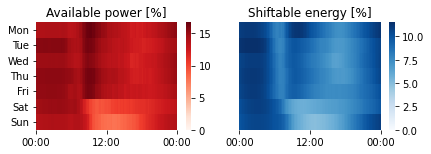

In [77]:
grid_id = 176
grid_dir = root_dir + r'\{}'.format(grid_id)
flexibility_bands = import_flexibility_bands(grid_dir, ["home", "work"])
plot_hm_quarterly_percent(flexibility_bands["upper_power"].sum(axis=1),
                          flexibility_bands["upper_energy"].sum(axis=1)-flexibility_bands["lower_energy"].sum(axis=1))

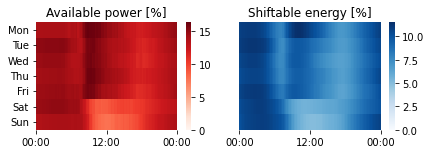

In [78]:
grid_id = 177
grid_dir = root_dir + r'\{}'.format(grid_id)
flexibility_bands = import_flexibility_bands(grid_dir, ["home", "work"])
plot_hm_quarterly_percent(flexibility_bands["upper_power"].sum(axis=1),
                          flexibility_bands["upper_energy"].sum(axis=1)-flexibility_bands["lower_energy"].sum(axis=1))

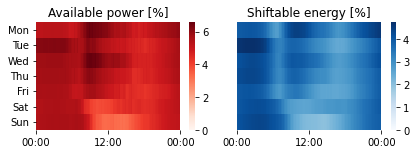

In [79]:
grid_id = 1056
grid_dir = root_dir + r'\{}'.format(grid_id)
flexibility_bands = import_flexibility_bands(grid_dir, ["home", "work"])
plot_hm_quarterly_percent(flexibility_bands["upper_power"].sum(axis=1),
                          flexibility_bands["upper_energy"].sum(axis=1)-flexibility_bands["lower_energy"].sum(axis=1))

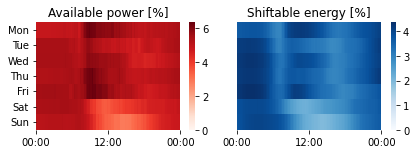

In [80]:
grid_id = 1690
grid_dir = root_dir + r'\{}'.format(grid_id)
flexibility_bands = import_flexibility_bands(grid_dir, ["home", "work"])
plot_hm_quarterly_percent(flexibility_bands["upper_power"].sum(axis=1),
                          flexibility_bands["upper_energy"].sum(axis=1)-flexibility_bands["lower_energy"].sum(axis=1))

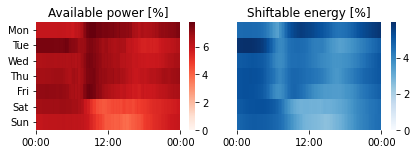

In [81]:
grid_id = 1811
grid_dir = root_dir + r'\{}'.format(grid_id)
flexibility_bands = import_flexibility_bands(grid_dir, ["home", "work"])
plot_hm_quarterly_percent(flexibility_bands["upper_power"].sum(axis=1),
                          flexibility_bands["upper_energy"].sum(axis=1)-flexibility_bands["lower_energy"].sum(axis=1))

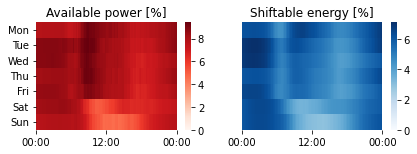

In [82]:
grid_id = 2534
grid_dir = root_dir + r'\{}'.format(grid_id)
flexibility_bands = import_flexibility_bands(grid_dir, ["home", "work"])
plot_hm_quarterly_percent(flexibility_bands["upper_power"].sum(axis=1),
                          flexibility_bands["upper_energy"].sum(axis=1)-flexibility_bands["lower_energy"].sum(axis=1))

**Decision**: *Cut will still be at 7am*, might have to be changed in other weeks

## Check 2: Cumulative charging demand
Compare the cumulative charging demand and decide whether the conditions on start and end energy level have to be changed

In [1]:
grid_id = 176
